In [1]:
contributor = "Nada"

## EDA

### Step 1: Import Libraries

In [7]:
import pandas as pd
import json
import numpy as np
import csv
from datetime import datetime
import os
import glob
# from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.ensemble import RandomForestRegressor
import plotly.graph_objects as go
# from pandarallel import pandarallel
import matplotlib.pyplot as plt
# pandarallel.initialize(progress_bar=True)
# import pytz
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans
import numpy as np
from shapely.geometry import MultiPoint
from shapely.ops import unary_union

In [34]:
import matplotlib.pyplot as plt

### Step 2: Load Data

In [3]:
# os.chdir("../")

In [4]:
os.getcwd()

'd:\\Senior Project - Main Workspace\\eta-rfr'

In [5]:
# Directory and file name pattern
directory = 'Cleaning/trial_week/clean_data'
file_base = 'clean_2024-01-'


# Generate the list of file names
files_names = [f'{file_base}{i}.json' for i in range(25, 32)] # last week of January 
# Generate the list of file directories
files = [os.path.join(directory, file_name) for file_name in files_names]

data = []

In [6]:
# Load data from each JSON file
for file_name in files:
    with open(file_name, 'r') as file:
        for line in file:
            data.append(json.loads(line))

# Create a DataFrame
df = pd.DataFrame(data)

# Step 1: Drop the 'time_diff' attribute if it exists
if 'time_diff' in df.columns:
    df.drop('time_diff', axis=1, inplace=True)

# # Step 2: Redefine the features after dropping 'time_diff'
# X = df_features.drop(columns=['time_diff'], errors='ignore')

# Calculate trip time in seconds
df['trip_time'] = df['time']

# Now, drop the 'time' column
df.drop(columns=['time'], inplace=True)

# Drop rows with missing values (if any)
df.dropna(inplace=True)

In [8]:
# Load pooling data
pooling_file_path = 'Cleaning/careems data/anon_pooling_jan_24_amman.csv' 
df_pooling = pd.read_csv(pooling_file_path)

In [10]:
# Load merachant data
merch_file_path = 'merchants_csv/all_merchant_info.csv' 
merchants_df = pd.read_csv(merch_file_path)

In [11]:
merchants_df.columns

Index(['order_id', 'merchant_id', 'day', 'merchant_lat', 'merchant_lng'], dtype='object')

#### Left join merchants on the pings df

In [12]:
# First merge merchants_df with df_pooling on 'order_id'
merged_pooling = df_pooling.merge(merchants_df[['order_id', 'merchant_id']], on='order_id', how='left')

# Now merge the resulting DataFrame with df on 'trip_id' (matching booking_id in df_pooling)
df = df.merge(merged_pooling[['booking_id', 'merchant_id']], left_on='trip_id', right_on='booking_id', how='left')

df = df.drop(columns=['booking_id'])

# Check how many 'merchant_id' values are null after the merge
null_merchant_count = df['merchant_id'].isnull().sum()

# Output the count of null 'merchant_id'
print(null_merchant_count)


0


In [13]:
df.columns

Index(['trip_id', 'time_gap', 'dist', 'lats', 'driverID', 'weekID', 'timeID',
       'dateID', 'lngs', 'dist_gap', 'trip_time', 'merchant_id'],
      dtype='object')

In [14]:
# Group by 'merchant_id' and count the number of rows in each group
merchant_group_counts = df.groupby('merchant_id').size().reset_index(name='count')

# Filter the groups where the count is greater than 1
filtered_merchant_groups = merchant_group_counts[merchant_group_counts['count'] > 1]

max_count = filtered_merchant_groups['count'].max()


# Display the filtered result
print(filtered_merchant_groups)

# Display the maximum count     
print("\nLargest group count:", max_count)


                                            merchant_id  count
0     0016fcd6207e1024e67d4679502c29d9588b8a289ca6f7...      5
1     002225f0f3a28cbc13591d70a1ec6ac3f254ff0ecd9c9c...     62
2     004af377dd4cce3fd9d97a296892c55e79bed133ddb62f...     49
3     008371d0b2d58e84ef29ef8b42c972e7789964e4df80a3...      4
4     0083c5defc22769e7e35a5966fbef22324050f611eb0f5...     72
...                                                 ...    ...
1707  ff7258ccf1ca2ab5a90302200d89b8cc89998192406a1f...     11
1709  ff7ec3b19bb826359a4d480cae5cd58fbabc9211908758...      3
1710  ffc06b495b2be53497f7673db10fbf006fc05ca3ea869b...     48
1711  ffcab9cd6a9a7c9b7f3c722f55d1d23f3060c53208fbbf...      2
1712  ffdf5861dec7d9c83de6195c8f517469103e60e4fa7933...      2

[1480 rows x 2 columns]

Largest group count: 576


### Step 3: Stationarity Detection

##### Miscellaneous

In [15]:
os.getcwd()

'd:\\Senior Project - Main Workspace\\eta-rfr'

In [16]:
os.chdir('Splitting')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45080 entries, 0 to 45079
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   trip_id      45080 non-null  object 
 1   time_gap     45080 non-null  object 
 2   dist         45080 non-null  float64
 3   lats         45080 non-null  object 
 4   driverID     45080 non-null  object 
 5   weekID       45080 non-null  int64  
 6   timeID       45080 non-null  int64  
 7   dateID       45080 non-null  int64  
 8   lngs         45080 non-null  object 
 9   dist_gap     45080 non-null  object 
 10  trip_time    45080 non-null  float64
 11  merchant_id  45080 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.1+ MB


#### Stationarity Detection for all trips

In [18]:
def detect_stationary_intervals(df, output_path='stationary_intervals_all_trips.csv'):
    results = []
    for index, row in df.iterrows():
        trip_id = row['trip_id']
        lats = np.array(row['lats'])
        lngs = np.array(row['lngs'])
        time_gap = np.array(row['time_gap'])
        
        # Compute differences between consecutive points directly from lat/lng arrays
        lat_diff = np.abs(np.diff(lats))
        lng_diff = np.abs(np.diff(lngs))

        # Identify stationary intervals (where there is no change in both lat and lng)
        stationary_indices = np.where((lat_diff == 0) & (lng_diff == 0))[0]
        
        # Group consecutive stationary indices into intervals
        if len(stationary_indices) > 0:
            start_idx = stationary_indices[0]
            for i in range(1, len(stationary_indices)):
                # If the current index is not consecutive, close the interval
                if stationary_indices[i] != stationary_indices[i - 1] + 1:
                    end_idx = stationary_indices[i - 1]
                    # Save the interval only if it has more than one index
                    if end_idx > start_idx:
                        interval = {
                            "trip_id": trip_id,
                            "start_idx": int(start_idx),
                            "end_idx": int(end_idx)+1,
                            "start_lat": float(lats[start_idx]),
                            "start_lng": float(lngs[start_idx]),
                            "end_lat": float(lats[end_idx+1]),
                            "end_lng": float(lngs[end_idx+1]),
                            "time_elapsed": float(time_gap[end_idx+1] - time_gap[start_idx])
                        }
                        results.append(interval)
                    # Start a new interval
                    start_idx = stationary_indices[i]
            # Add the last interval if it has more than one index
            end_idx = stationary_indices[-1]
            if end_idx > start_idx:
                interval = {
                    "trip_id": trip_id,
                    "start_idx": int(start_idx),
                    "end_idx": int(end_idx)+1,
                    "start_lat": float(lats[start_idx]),
                    "start_lng": float(lngs[start_idx]),
                    "end_lat": float(lats[end_idx+1]),
                    "end_lng": float(lngs[end_idx+1]),
                    "time_elapsed": float(time_gap[end_idx+1] - time_gap[start_idx])
                }
                results.append(interval)

    # Convert results to a DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_path, index=False)

    print(f"Stationary intervals saved to {output_path}")
    return results_df

stationary_df1 = detect_stationary_intervals(df)

Stationary intervals saved to stationary_intervals_all_trips.csv


#### Truncate based on stationary intervals found, find new intervals post truncation, and longest intervals

In [19]:

def truncate_trips_if_stationary(df, stationary_df):
    truncated_trips = []

    # Iterate over each trip in the df
    for index, row in df.iterrows():
        trip_id = row['trip_id']
        lats = row['lats']
        lngs = row['lngs']
        time_gap = row['time_gap']
        dist_gap = row['dist_gap']
        dist = row['dist']
        trip_time = row['trip_time']

        # Get the last coordinates of the trip
        last_lat, last_lng = lats[-1], lngs[-1]

        # Find the corresponding stationary intervals for this trip
        intervals = stationary_df[stationary_df['trip_id'] == trip_id]

        if not intervals.empty:
            # Get the last stationary interval for this trip
            last_interval = intervals.iloc[-1]

            # Get the coordinates and time elapsed for the last stationary interval
            interval_lats = lats[last_interval['start_idx']:last_interval['end_idx'] + 1]
            interval_lngs = lngs[last_interval['start_idx']:last_interval['end_idx'] + 1]
            interval_time_gap = time_gap[last_interval['start_idx']:last_interval['end_idx'] + 1]
            interval_dist_gap = dist_gap[last_interval['start_idx']:last_interval['end_idx'] + 1]

            interval_lat, interval_lng = last_interval['end_lat'], last_interval['end_lng']
            time_elapsed = last_interval['time_elapsed']

            # Check if the last stationary interval's coordinates match the last trip coordinates
            if (last_lat == interval_lat and last_lng == interval_lng) and time_elapsed > 10:
                # Keep only the first part of the stationary segment
                truncated_trip = {
                    'trip_id': trip_id,
                    'lats': lats[:last_interval['start_idx'] + 1],
                    'lngs': lngs[:last_interval['start_idx'] + 1],
                    'time_gap': time_gap[:last_interval['start_idx'] + 1],
                    'dist_gap': dist_gap[:last_interval['start_idx'] + 1],
                    'dist': dist,  # Keep the original distance
                    'trip_time': time_gap[last_interval['start_idx']],  # Adjusted trip time
                    'driverID': row['driverID'],
                    'weekID': row['weekID'],
                    'timeID': row['timeID'],
                    'dateID': row['dateID'],
                    'merchant_id': row['merchant_id']
                }
                truncated_trips.append(truncated_trip)
            else:
                # If no truncation is needed, keep the original trip
                truncated_trips.append(row.to_dict())
        else:
            # If no stationary intervals exist, keep the original trip
            truncated_trips.append(row.to_dict())

    # Convert the list of truncated trips back into a DataFrame
    truncated_df = pd.DataFrame(truncated_trips)

    # Ensure all columns match the original schema
    for column in df.columns:
        if column not in truncated_df.columns:
            truncated_df[column] = None  # Add missing columns with default None values

    # Reorder columns to match the original DataFrame
    truncated_df = truncated_df[df.columns]

    return truncated_df

# Example usage
truncated_df = truncate_trips_if_stationary(df, stationary_df1)
truncated_df.to_csv('truncated_trips.csv', index=False)

print("Truncated trips saved to 'truncated_trips.csv'")

# Save to JSON as well
truncated_df_json = truncated_df.to_dict(orient='records')
with open('truncated_trips.json', 'w') as file:
    for json_obj in truncated_df_json:
        json.dump(json_obj, file)
        file.write('\n')


Truncated trips saved to 'truncated_trips.csv'


In [20]:
def detect_stationary_intervals(df, output_path='stationary_intervals_all_trips_truncated.csv'):
    results = []
    for index, row in df.iterrows():
        trip_id = row['trip_id']
        lats = np.array(row['lats'])
        lngs = np.array(row['lngs'])
        time_gap = np.array(row['time_gap'])
        
        # Compute differences between consecutive points directly from lat/lng arrays
        lat_diff = np.abs(np.diff(lats))
        lng_diff = np.abs(np.diff(lngs))

        # Identify stationary intervals (where there is no change in both lat and lng)
        stationary_indices = np.where((lat_diff == 0) & (lng_diff == 0))[0]
        
        # Group consecutive stationary indices into intervals
        if len(stationary_indices) > 0:
            start_idx = stationary_indices[0]
            for i in range(1, len(stationary_indices)):
                # If the current index is not consecutive, close the interval
                if stationary_indices[i] != stationary_indices[i - 1] + 1:
                    end_idx = stationary_indices[i - 1]
                    # Save the interval only if it has more than one index
                    if end_idx > start_idx:
                        interval = {
                            "trip_id": trip_id,
                            "start_idx": int(start_idx),
                            "end_idx": int(end_idx)+1,
                            "start_lat": float(lats[start_idx]),
                            "start_lng": float(lngs[start_idx]),
                            "end_lat": float(lats[end_idx+1]),
                            "end_lng": float(lngs[end_idx+1]),
                            "time_elapsed": float(time_gap[end_idx+1] - time_gap[start_idx])
                        }
                        results.append(interval)
                    # Start a new interval
                    start_idx = stationary_indices[i]
            # Add the last interval if it has more than one index
            end_idx = stationary_indices[-1]
            if end_idx > start_idx:
                interval = {
                    "trip_id": trip_id,
                    "start_idx": int(start_idx),
                    "end_idx": int(end_idx)+1,
                    "start_lat": float(lats[start_idx]),
                    "start_lng": float(lngs[start_idx]),
                    "end_lat": float(lats[end_idx+1]),
                    "end_lng": float(lngs[end_idx+1]),
                    "time_elapsed": float(time_gap[end_idx+1] - time_gap[start_idx])
                }
                results.append(interval)

    # Convert results to a DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_path, index=False)

    print(f"Stationary intervals saved to {output_path}")
    return results_df

stationary_df = detect_stationary_intervals(truncated_df)

Stationary intervals saved to stationary_intervals_all_trips_truncated.csv


In [21]:
df=truncated_df

In [22]:
def extract_longest_stationary_interval(stationary_df):
    # Find the longest stationary interval for each trip_id based on time_elapsed
    longest_intervals = stationary_df.loc[stationary_df.groupby('trip_id')['time_elapsed'].idxmax()]

    longest_intervals.reset_index(drop=True, inplace=True)
    
    return longest_intervals

longest_intervals_df = extract_longest_stationary_interval(stationary_df)
longest_intervals_df.to_csv('longest_stationary_intervals_truncated.csv', index=False)


##### combined df with pooling info and longest interval info

In [23]:
def create_combined_csvs(longest_intervals_df, pooling_df, output_path1='combined_trip_data.csv'):
    
    # Rename 'booking_id' to 'trip_id' in pooling_df for consistency
    pooling_df = pooling_df.rename(columns={'booking_id': 'trip_id'})
    
    # Create csv file to combine pooling_df and longest_intervals_df
    combined_df = (
        longest_intervals_df[['trip_id', 'start_lat', 'start_lng']]
        .merge(pooling_df[['trip_id', 'pickup_latitude', 'pickup_longitude']], on='trip_id', how='inner')
    )

    # Rename columns for clarity in the combined data
    combined_df = combined_df.rename(columns={
        'start_lat': 'stationary_df_lat',
        'start_lng': 'stationary_df_lng',
        'pickup_latitude': 'pooling_df_lat',
        'pickup_longitude': 'pooling_df_lng'
    })

    # # Save the combined data to CSV
    # combined_df.to_csv(output_path1, index=False)
    # print(f"Combined data saved to {output_path1}")
    
    return combined_df

combined_df = create_combined_csvs(longest_intervals_df, df_pooling)

In [24]:
combined_df = combined_df.merge(df[['trip_id', 'merchant_id']], on='trip_id', how='left')

#### update coords in pooling to match majority

In [25]:
import pandas as pd
import numpy as np

def check_inconsistent_groups_with_tolerance_fix(combined_df, tolerance=0.0, output_path='merchant_lat_lng_mismatch.csv'):
    # Lists to store inconsistent groups and detailed non-unique counts
    inconsistent_groups = []
    nonunique_info = []

    for merchant_id, group in combined_df.groupby('merchant_id'):
        # Extract latitude and longitude values for the group
        lat_values = group['pooling_df_lat'].values
        lng_values = group['pooling_df_lng'].values

        # Count occurrences of each latitude and longitude
        lat_counts = pd.Series(lat_values).value_counts()
        lng_counts = pd.Series(lng_values).value_counts()

        # Identify the majority (most common) latitude and longitude
        majority_lat = lat_counts.idxmax()
        majority_lng = lng_counts.idxmax()

        # Filter out the non-majority coordinates
        non_majority_lats = lat_counts[lat_counts.index != majority_lat]
        non_majority_lngs = lng_counts[lng_counts.index != majority_lng]

        # If there are non-majority coordinates, store the information
        if not non_majority_lats.empty or not non_majority_lngs.empty:
            inconsistent_groups.append(group)

            # Store the non-unique information for this merchant_id
            nonunique_info.append({
                'merchant_id': merchant_id,
                'non_majority_lats': non_majority_lats.to_dict(),  # Non-majority latitudes and their counts
                'non_majority_lngs': non_majority_lngs.to_dict(),  # Non-majority longitudes and their counts
                'group_size': len(group)
            })

    # Combine all inconsistent groups into a single DataFrame
    if inconsistent_groups:
        inconsistent_df = pd.concat(inconsistent_groups)
        # Save the inconsistent groups to a CSV file
        inconsistent_df.to_csv(output_path, index=False)

        print(f"Inconsistent groups saved to {output_path}")
        print(f"Number of inconsistent groups: {len(inconsistent_groups)}")

        # Save the detailed non-majority value counts to a CSV
        nonunique_df = pd.DataFrame(nonunique_info)
        nonunique_df.to_csv('non_majority_counts.csv', index=False)
    else:
        print("No inconsistencies found.")

# Example usage (assuming combined_df is already created)
check_inconsistent_groups_with_tolerance_fix(combined_df)


Inconsistent groups saved to merchant_lat_lng_mismatch.csv
Number of inconsistent groups: 987


In [26]:
def correct_pooling_coordinates_with_nonmajority(non_majority_path, combined_df, pooling_df):
    # Load the non-majority counts from CSV
    non_majority_df = pd.read_csv(non_majority_path)

    corrected_trip_ids = []  # Track the trip IDs that are corrected

    # Iterate over each merchant in the non-majority DataFrame
    for _, row in non_majority_df.iterrows():
        merchant_id = row['merchant_id']

        # Get the majority latitude and longitude for this merchant from combined_df
        majority_lat = combined_df[combined_df['merchant_id'] == merchant_id]['pooling_df_lat'].mode()[0]
        majority_lng = combined_df[combined_df['merchant_id'] == merchant_id]['pooling_df_lng'].mode()[0]

        # Find the trip IDs with non-majority coordinates
        merchant_group = combined_df[combined_df['merchant_id'] == merchant_id]
        incorrect_trips = merchant_group[
            (~np.isclose(merchant_group['pooling_df_lat'], majority_lat, atol=0.001)) |
            (~np.isclose(merchant_group['pooling_df_lng'], majority_lng, atol=0.001))
        ]

        # Update the coordinates in pooling_df for the incorrect trips
        for trip_id in incorrect_trips['trip_id']:
            pooling_df.loc[pooling_df['booking_id'] == trip_id, ['pickup_latitude', 'pickup_longitude']] = [
                majority_lat, majority_lng
            ]
            corrected_trip_ids.append(trip_id)

    # Save the updated pooling_df
    pooling_df.to_csv('corrected_pooling_jan.csv', index=False)

    # Save the corrected trip IDs to a JSON or CSV (optional)
    with open('corrected_trip_ids.json', 'w') as f:
        json.dump(corrected_trip_ids, f)

    print(f"Corrected {len(corrected_trip_ids)} trip coordinates.")
    return corrected_trip_ids, pooling_df

# Example usage
corrected_trip_ids, updated_pooling_df = correct_pooling_coordinates_with_nonmajority(
    'non_majority_counts.csv', combined_df, df_pooling
)


Corrected 531 trip coordinates.


#### extract non matching coords and drop them from df and longest stationary

In [27]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Compute differences
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Apply Haversine formula
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance

def extract_non_matching_coordinates(combined_df_no_pickup_df):
    # Identify rows where the stationary coordinates do not match pooling coordinates
    non_matching_df = combined_df_no_pickup_df[
        (combined_df_no_pickup_df['stationary_df_lat'] != combined_df_no_pickup_df['pooling_df_lat']) |
        (combined_df_no_pickup_df['stationary_df_lng'] != combined_df_no_pickup_df['pooling_df_lng'])
    ]

    # calculate the distance between the coordinates
    non_matching_df['distance_km'] = haversine(
        non_matching_df['stationary_df_lat'],
        non_matching_df['stationary_df_lng'],
        non_matching_df['pooling_df_lat'],
        non_matching_df['pooling_df_lng']
    )

    return non_matching_df

non_matching_entries = extract_non_matching_coordinates(combined_df)
# print(non_matching_entries.head())

# Save the non-matching entries to a CSV file
non_matching_entries.to_csv('non_matching_coordinates_fixed_pooling.csv', index=False)
print("Non-matching coordinate entries saved to non_matching_coordinates.csv")
print(non_matching_entries.count())


C:\Users\nadab\AppData\Local\Temp\ipykernel_26592\226864586.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_matching_df['distance_km'] = haversine(


Non-matching coordinate entries saved to non_matching_coordinates.csv
trip_id              10071
stationary_df_lat    10071
stationary_df_lng    10071
pooling_df_lat       10071
pooling_df_lng       10071
merchant_id          10071
distance_km          10071
dtype: int64


In [28]:
# Drop non-matching trips from `df` and `longest_intervals_df`
def drop_non_matching_trips(df, longest_intervals_df, non_matching_entries):
    # Extract the trip IDs from non-matching entries
    non_matching_trip_ids = non_matching_entries['trip_id'].unique()

    # Drop these trips from both dataframes
    df_filtered = df[~df['trip_id'].isin(non_matching_trip_ids)]
    longest_intervals_filtered = longest_intervals_df[~longest_intervals_df['trip_id'].isin(non_matching_trip_ids)]

    return df_filtered, longest_intervals_filtered

# Example usage to filter `df` and `longest_intervals_df`
df, longest_intervals_df = drop_non_matching_trips(df, longest_intervals_df, non_matching_entries)


print("Filtered DataFrames saved.")

Filtered DataFrames saved.


In [29]:
df.shape

(35009, 12)

### Step 4: Splitting trips into 3 segments (d2m, w2m, m2c)

#### Split trips based on stationarity

In [30]:

def adjust_gaps_with_original_pattern(original_gaps, new_gaps):
    """
    Adjust new gaps based on the pattern of change in the original gaps.
    The new gaps will start from 0 but follow the same incremental differences.
    """
    if len(original_gaps) <= 1 or len(new_gaps) == 0:
        return new_gaps  # No meaningful adjustment needed

    # Calculate the incremental changes (differences) in the original gaps
    original_diffs = np.diff(original_gaps)

    # Start the new gaps from 0
    adjusted_gaps = [0]

    # Apply the original differences to the new gaps
    for i in range(1, len(new_gaps)):
        diff = original_diffs[(i - 1) % len(original_diffs)]
        adjusted_gaps.append(adjusted_gaps[-1] + diff)

    return adjusted_gaps

def segment_trips(df, longest_intervals_df):
    road_list = []
    second_segment_list = []

    # Iterate over each entry in the df dataframe
    for index, row in df.iterrows():
        trip_id = row['trip_id']
        interval = longest_intervals_df[longest_intervals_df['trip_id'] == trip_id]
        lats = row['lats']
        lngs = row['lngs']
        time_gap = row['time_gap']
        dist_gap = row['dist_gap']

        if not interval.empty:
            start_idx = interval['start_idx'].values[0]
            end_idx = interval['end_idx'].values[0]

            # First segment
            first_segment = {
                'trip_id': trip_id,
                'time_gap': time_gap[:start_idx],
                'dist': dist_gap[start_idx - 1] if start_idx > 0 else 0,
                'trip_time': time_gap[start_idx - 1] if start_idx > 0 else 0,
                'driverID': row['driverID'],
                'weekID': row['weekID'],
                'timeID': row['timeID'],
                'dateID': row['dateID'],
                'dist_gap': dist_gap[:start_idx],
                'lats': lats[:start_idx],
                'lngs': lngs[:start_idx],
                'time_offset': 0,
                'segmentID': 1
            }

            # Second segment (stationary)
            stationary_time_gap = time_gap[start_idx:end_idx + 1]
            stationary_dist_gap = dist_gap[start_idx:end_idx + 1]

            stationary_time_gap = [time - stationary_time_gap[0] for time in stationary_time_gap]
            stationary_dist_gap = [dist - stationary_dist_gap[0] for dist in stationary_dist_gap]

            second_segment = {
                'trip_id': trip_id,
                'time_gap': stationary_time_gap,
                'dist': stationary_dist_gap[-1] if len(stationary_dist_gap) > 0 else 0,
                'trip_time': stationary_time_gap[-1] if len(stationary_time_gap) > 0 else 0,
                'driverID': row['driverID'],
                'weekID': row['weekID'],
                'timeID': row['timeID'],
                'dateID': row['dateID'],
                'dist_gap': stationary_dist_gap,
                'lats': lats[start_idx:end_idx + 1],
                'lngs': lngs[start_idx:end_idx + 1],
                'time_offset': time_gap[start_idx],
                'merchant': row['merchant_id']
            }

            # Third segment (after stationary)
            new_time_gap = time_gap[end_idx + 1:]
            new_dist_gap = dist_gap[end_idx + 1:]

            # Adjust the gaps using the pattern from the original trip
            adjusted_time_gap = adjust_gaps_with_original_pattern(time_gap[end_idx + 1:], new_time_gap)
            adjusted_dist_gap = adjust_gaps_with_original_pattern(dist_gap[end_idx + 1:], new_dist_gap)
            time_offset3 = time_gap[end_idx + 1] if len(time_gap) > end_idx + 1 else 0

            third_segment = {
                'trip_id': trip_id,
                'time_gap': adjusted_time_gap,
                'dist': adjusted_dist_gap[-1] if len(adjusted_dist_gap) > 0 else 0,
                'trip_time': adjusted_time_gap[-1] if len(adjusted_time_gap) > 0 else 0,
                'driverID': row['driverID'],
                'weekID': row['weekID'],
                'timeID': row['timeID']+round((time_offset3/60),1),
                'dateID': row['dateID'],
                'dist_gap': adjusted_dist_gap,
                'lats': lats[end_idx + 1:],
                'lngs': lngs[end_idx + 1:],
                'time_offset': time_offset3,
                'segmentID': 3
            }
        else:
            print(f"No interval found for trip_id: {trip_id}")

        # Add segments to their respective lists
        if len(first_segment['time_gap']) > 1:
            road_list.append(first_segment)

        if len(third_segment['time_gap']) > 1:
            road_list.append(third_segment)

        if len(second_segment['time_gap']) > 1:
            second_segment_list.append(second_segment)

    # Convert the lists to DataFrames
    road_df = pd.DataFrame(road_list)
    second_segment_df = pd.DataFrame(second_segment_list)

    return road_df, second_segment_df

road_df, second_segment_df = segment_trips(df, longest_intervals_df)

No interval found for trip_id: 25049734158c2944703546bdc2cbe5740170230779e858db275cb6512aaa0047
No interval found for trip_id: 4ad4bdf931291e3f2176bef563091893e0bde118f28a2ef5b172ece38949ed38
No interval found for trip_id: 5057cb61e831386cd034d24462a4f6ecebecb3606bc2d39d4c991fd04b56e413
No interval found for trip_id: 620950188eebce63b6bf5be22cb280dbb8d75b5cef8904b6de30bb892d2a1c3a
No interval found for trip_id: 64186edda7362e34c7598fe8af53c01cde6071b3d932380eaa30299419712632
No interval found for trip_id: 07a2f3cdf28096c27c4c2b81bcfafe30a96095097f6e96e79878f714a9ec648c
No interval found for trip_id: 6299a27e7d370d6904a05073fdd554e0efbf09f0d9458d7e0f677e75644c2e34
No interval found for trip_id: 65d99e964c50a5eed233fe9a7864114c1d91cf6b6ba542bbf4906a998d4df27f
No interval found for trip_id: 7d71d55894365ccad46d7e7c533997c58e200cc235919b0c817944af8b5226a1
No interval found for trip_id: 01ff05c850fb030d8174a48d70a7327747dd0177030bc5cad10f5c9d25b95b33
No interval found for trip_id: ec0286dc1

In [33]:
# Step 1: Find trips that have only one occurrence in road_df
single_occurrence_trips = road_df['trip_id'].value_counts()
single_occurrence_trips = single_occurrence_trips[single_occurrence_trips == 1].index

# Step 2: Filter the DataFrame to include only trips that have one occurrence
filtered_single_trips_df = road_df[road_df['trip_id'].isin(single_occurrence_trips)]

# Step 3: Filter further to ensure segmentID is 3
filtered_single_trips_segment3_df = filtered_single_trips_df[filtered_single_trips_df['segmentID'] == 1]

# Step 4: Remove these trips from road_df
road_df = road_df[~road_df['trip_id'].isin(filtered_single_trips_segment3_df['trip_id'])]

# Iterate over each dateID in the specified range (24 to 30)
for date_id in range(24, 31):
    # Filter road_df and second_segment_df for the current dateID
    road_df_filtered = road_df[road_df['dateID'] == date_id]
    second_segment_df_filtered = second_segment_df[second_segment_df['dateID'] == date_id]
    
    # Convert to JSON format
    road_json = road_df_filtered.to_dict(orient='records')
    second_seg_json = second_segment_df_filtered.to_dict(orient='records')

    # Generate filenames with dateID + 1 (to match the desired format)
    road_file_name = f'Segmented Trial Week/Segmented_Trips_01_{date_id + 1}.json'
    segment_file_name = f'Segmented Trial Week/Merchants_Segments_01_{date_id + 1}.json'

    # Save road segments to JSON
    with open(road_file_name, 'w') as file:
        for json_obj in road_json:
            json.dump(json_obj, file)
            file.write('\n')

    # Save merchant segments to JSON
    with open(segment_file_name, 'w') as file:
        for json_obj in second_seg_json:
            json.dump(json_obj, file)
            file.write('\n')

    print(f"Segments 1 & 3 saved to '{road_file_name}'")
    print(f"Segment 2 with wait times saved to '{segment_file_name}'")

# Print columns for verification
print(road_df.columns)
print(second_segment_df.columns)


Segments 1 & 3 saved to 'Segmented Trial Week/Segmented_Trips_01_25.json'
Segment 2 with wait times saved to 'Segmented Trial Week/Merchants_Segments_01_25.json'
Segments 1 & 3 saved to 'Segmented Trial Week/Segmented_Trips_01_26.json'
Segment 2 with wait times saved to 'Segmented Trial Week/Merchants_Segments_01_26.json'
Segments 1 & 3 saved to 'Segmented Trial Week/Segmented_Trips_01_27.json'
Segment 2 with wait times saved to 'Segmented Trial Week/Merchants_Segments_01_27.json'
Segments 1 & 3 saved to 'Segmented Trial Week/Segmented_Trips_01_28.json'
Segment 2 with wait times saved to 'Segmented Trial Week/Merchants_Segments_01_28.json'
Segments 1 & 3 saved to 'Segmented Trial Week/Segmented_Trips_01_29.json'
Segment 2 with wait times saved to 'Segmented Trial Week/Merchants_Segments_01_29.json'
Segments 1 & 3 saved to 'Segmented Trial Week/Segmented_Trips_01_30.json'
Segment 2 with wait times saved to 'Segmented Trial Week/Merchants_Segments_01_30.json'
Segments 1 & 3 saved to 'Seg

In [36]:
road_df.describe()

dist     trip_time        weekID        timeID        dateID  \
count  64611.000000  64611.000000  64611.000000  64611.000000  64611.000000   
mean       4.245647    545.493941      2.995945    882.030065     26.887450   
std       25.907593    437.792605      1.946319    280.359040      2.044701   
min        0.000000      0.000000      0.000000      3.000000     24.000000   
25%        0.883395    208.500000      1.000000    686.000000     25.000000   
50%        2.373664    432.000000      3.000000    904.200000     27.000000   
75%        5.662286    780.000000      5.000000   1094.900000     29.000000   
max     2872.321048   4980.000000      6.000000   1437.400000     30.000000   

        time_offset     segmentID  
count  64611.000000  64611.000000  
mean     462.391729      2.081147  
std      537.200286      0.996710  
min        0.000000      1.000000  
25%        0.000000      1.000000  
50%      344.000000      3.000000  
75%      815.000000      3.000000  
max     6442.000000      3.000000

In [46]:
road_df_new.describe()

dist     trip_time        weekID        timeID        dateID  \
count  64611.000000  64611.000000  64611.000000  64611.000000  64611.000000   
mean       4.245647    545.493941      2.995945    882.030065     26.887450   
std       25.907593    437.792605      1.946319    280.359040      2.044701   
min        0.000000      0.000000      0.000000      3.000000     24.000000   
25%        0.883395    208.500000      1.000000    686.000000     25.000000   
50%        2.373664    432.000000      3.000000    904.200000     27.000000   
75%        5.662286    780.000000      5.000000   1094.900000     29.000000   
max     2872.321048   4980.000000      6.000000   1437.400000     30.000000   

        time_offset     segmentID  
count  64611.000000  64611.000000  
mean     462.391729      2.081147  
std      537.200286      0.996710  
min        0.000000      1.000000  
25%        0.000000      1.000000  
50%      344.000000      3.000000  
75%      815.000000      3.000000  
max     6442.000000      3.000000

In [42]:
second_segment_df.describe()

dist     trip_time        weekID        timeID        dateID  \
count  35009.0  35009.000000  35009.000000  35009.000000  35009.000000   
mean       0.0    587.805764      2.981176    874.914708     26.907024   
std        0.0    392.575488      1.944636    282.744044      2.050928   
min        0.0     10.000000      0.000000      3.000000     24.000000   
25%        0.0    295.000000      1.000000    677.000000     25.000000   
50%        0.0    498.000000      3.000000    898.000000     27.000000   
75%        0.0    785.000000      5.000000   1090.000000     29.000000   
max        0.0   5824.000000      6.000000   1429.000000     30.000000   

        time_offset  
count  35009.000000  
mean     254.751550  
std      251.245861  
min        0.000000  
25%       77.000000  
50%      195.000000  
75%      358.000000  
max     3415.000000

In [34]:
os.getcwd()

'd:\\Senior Project - Main Workspace\\eta-rfr\\Splitting'

### Checkpoint - Read from files to save in dfs

In [4]:
import os
import json
import pandas as pd

# Initialize empty dataframes
road_df_list = []
second_segment_df_list = []

# Iterate over each dateID in the specified range (24 to 30)
for date_id in range(24, 31):
    # Generate filenames with dateID + 1 (to match the desired format)
    road_file_name = f'Splitting/Segmented Trial Week/Segmented_Trips_01_{date_id + 1}.json'
    segment_file_name = f'Splitting/Segmented Trial Week/Merchants_Segments_01_{date_id + 1}.json'
    
    # Check if the JSON files already exist
    if os.path.exists(road_file_name) and os.path.exists(segment_file_name):
        print(f"Loading segments from '{road_file_name}' and '{segment_file_name}'")
        
        # Load road segments from JSON
        with open(road_file_name, 'r') as file:
            road_json = [json.loads(line) for line in file]
        road_df_filtered = pd.DataFrame(road_json)
        
        # Load merchant segments from JSON
        with open(segment_file_name, 'r') as file:
            second_seg_json = [json.loads(line) for line in file]
        second_segment_df_filtered = pd.DataFrame(second_seg_json)
    
    else:
        # display that the files do not exist
        print(f"Files '{road_file_name}' and '{segment_file_name}' do not exist.")

        # # Filter road_df and second_segment_df for the current dateID
        # road_df_filtered = road_df[road_df['dateID'] == date_id]
        # second_segment_df_filtered = second_segment_df[second_segment_df['dateID'] == date_id]
        
        # # Convert to JSON format
        # road_json = road_df_filtered.to_dict(orient='records')
        # second_seg_json = second_segment_df_filtered.to_dict(orient='records')
        
        # # Save road segments to JSON
        # with open(road_file_name, 'w') as file:
        #     for json_obj in road_json:
        #         json.dump(json_obj, file)
        #         file.write('\n')

        # # Save merchant segments to JSON
        # with open(segment_file_name, 'w') as file:
        #     for json_obj in second_seg_json:
        #         json.dump(json_obj, file)
        #         file.write('\n')

        # print(f"Segments 1 & 3 saved to '{road_file_name}'")
        # print(f"Segment 2 with wait times saved to '{segment_file_name}'")
    
    # Append filtered data to lists
    road_df_list.append(road_df_filtered)
    second_segment_df_list.append(second_segment_df_filtered)

# Concatenate all filtered dataframes
road_df = pd.concat(road_df_list, ignore_index=True)
second_segment_df = pd.concat(second_segment_df_list, ignore_index=True)

# Print columns for verification
# print(road_df.columns)
# print(second_segment_df.columns)


Loading segments from 'Splitting/Segmented Trial Week/Segmented_Trips_01_25.json' and 'Splitting/Segmented Trial Week/Merchants_Segments_01_25.json'
Loading segments from 'Splitting/Segmented Trial Week/Segmented_Trips_01_26.json' and 'Splitting/Segmented Trial Week/Merchants_Segments_01_26.json'
Loading segments from 'Splitting/Segmented Trial Week/Segmented_Trips_01_27.json' and 'Splitting/Segmented Trial Week/Merchants_Segments_01_27.json'
Loading segments from 'Splitting/Segmented Trial Week/Segmented_Trips_01_28.json' and 'Splitting/Segmented Trial Week/Merchants_Segments_01_28.json'
Loading segments from 'Splitting/Segmented Trial Week/Segmented_Trips_01_29.json' and 'Splitting/Segmented Trial Week/Merchants_Segments_01_29.json'
Loading segments from 'Splitting/Segmented Trial Week/Segmented_Trips_01_30.json' and 'Splitting/Segmented Trial Week/Merchants_Segments_01_30.json'
Loading segments from 'Splitting/Segmented Trial Week/Segmented_Trips_01_31.json' and 'Splitting/Segmented

### Step 5: Order rush hours analysis - number of orders per time segment

In [5]:
# Define 2-hour segment ranges (in minutes)
two_hour_segments = [(i * 120, (i + 1) * 120) for i in range(12)]  # Each tuple is a (start, end) range in minutes
two_hour_labels = [f"{str(i*2).zfill(2)}:00 - {str(i*2+2).zfill(2)}:00" for i in range(12)]  # Two-hour labels in "HH:MM - HH:MM" format

# Function to determine which 2-hour segment a timeID belongs to
def get_two_hour_segment(timeID):
    for idx, (start, end) in enumerate(two_hour_segments):
        if start <= timeID < end:
            return two_hour_labels[idx]  # Return the corresponding 2-hour label
    return None  # Return None if the timeID is outside the 0-1440 range (but it shouldn't happen)

# Apply the 2-hour segment function to assign each row to a 2-hour segment based on timeID
road_df['two_hour_segment'] = road_df['timeID'].apply(get_two_hour_segment)

# Group by the 'two_hour_segment' column and count the number of rows (orders) in each segment
orders_per_two_hour_segment = road_df.groupby('two_hour_segment').size().reset_index(name='order_count')

# Write the result to a CSV file
# output_file_path = 'split_orders_per_two_hour_segment.csv'
# orders_per_two_hour_segment.to_csv(output_file_path, index=False)

# print(f"Results have been saved to {output_file_path}")


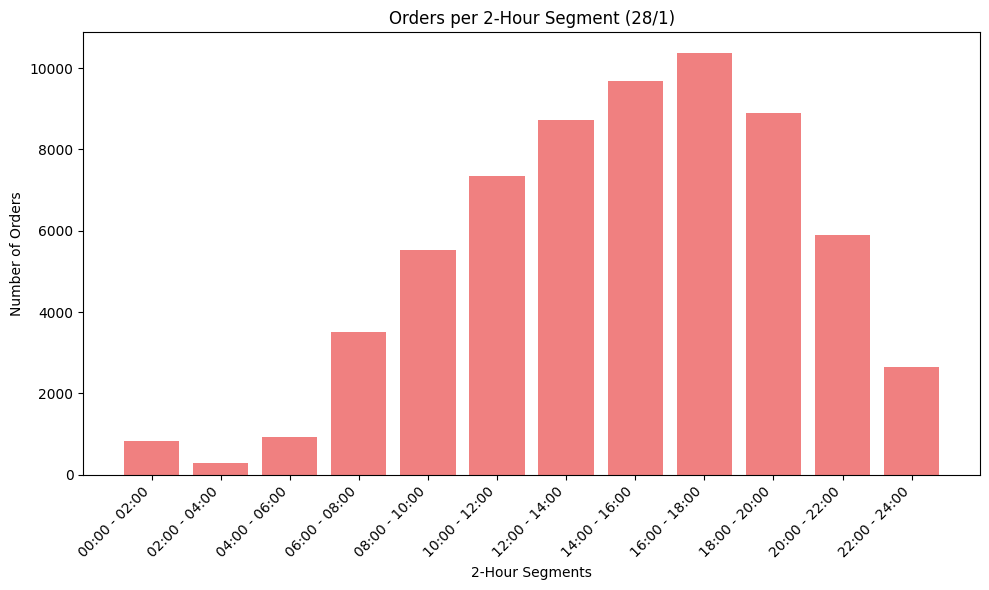

In [8]:
plt.figure(figsize=(10, 6))
plt.bar(orders_per_two_hour_segment['two_hour_segment'], orders_per_two_hour_segment['order_count'], color='lightcoral')
plt.xlabel('2-Hour Segments')
plt.ylabel('Number of Orders')
plt.title('Orders per 2-Hour Segment (28/1)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
# Define 1-hour segment ranges (in minutes)
hour_segments = [(i * 60, (i + 1) * 60) for i in range(24)]  # Each tuple is a (start, end) range in minutes
hour_labels = [f"{str(i).zfill(2)}:00 - {str(i+1).zfill(2)}:00" for i in range(24)]  # Hour labels in "HH:MM - HH:MM" format

# Function to determine which hour segment a timeID belongs to
def get_hour_segment(timeID):
    for idx, (start, end) in enumerate(hour_segments):
        if start <= timeID < end:
            return hour_labels[idx]  # Return the corresponding hour label
    return None  # Return None if the timeID is outside the 0-1440 range (but it shouldn't happen)

# Apply the hour segment function to assign each row to an hourly segment based on timeID
road_df['hour'] = road_df['timeID'].apply(get_hour_segment)

# Group by the 'hour' column and count the number of rows (orders) in each hour
orders_per_hour = road_df.groupby('hour').size().reset_index(name='order_count')

# Write the result to a CSV file
output_file_path = 'orders_per_hour_segment_trial_week.csv'
orders_per_hour.to_csv(output_file_path, index=False)

print(f"Results have been saved to {output_file_path}")


Results have been saved to orders_per_hour_segment_trial_week.csv


### Step 6: Clustering start and end coordinates of trips

In [12]:
total_coords = road_df['lats'].apply(len).sum()

print(f"Total number of coordinates in the DataFrame: {total_coords}")

Total number of coordinates in the DataFrame: 5532640


In [ ]:

all_lats = [lat for sublist in road_df['lats'] for lat in sublist]
all_lngs = [lng for sublist in road_df['lngs'] for lng in sublist]
coords = np.array(list(zip(all_lats, all_lngs)))


num_clusters = 250  
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(coords)
cluster_labels = kmeans.labels_

coord_to_cluster = dict(zip(map(tuple, coords), cluster_labels))

def get_cluster_id(lat, lon):
    return coord_to_cluster.get((lat, lon), None)


##### Trips that have the same src and dst within the same cluster (with Visualization) Different visuals

In [ ]:
df['start_cluster'] = [get_cluster_id(row['lats'][0], row['lngs'][0]) for _, row in df.iterrows()]
df['end_cluster'] = [get_cluster_id(row['lats'][-1], row['lngs'][-1]) for _, row in df.iterrows()]

# Step 3: Check if a trip has the same starting and destination cluster
df['same_cluster'] = df['start_cluster'] == df['end_cluster']

# Step 4: Prepare map
average_lat = sum(all_lats) / len(all_lats)
average_lon = sum(all_lngs) / len(all_lngs)
m = folium.Map(location=[average_lat, average_lon], zoom_start=12)

# Add clustering to handle the large number of points
marker_cluster = MarkerCluster().add_to(m)

# Step 5: Create and add polygons for each cluster
cluster_points = {}
for coord, label in zip(coords, cluster_labels):
    if label not in cluster_points:
        cluster_points[label] = []
    cluster_points[label].append(coord)

for label, points in cluster_points.items():
    if len(points) > 1:
        # Create a shapely polygon from the points
        multipoint = MultiPoint(points)
        convex_hull = multipoint.convex_hull
        coords = np.array(convex_hull.exterior.coords)
        # Convert to a list of lists for folium
        folium.Polygon(locations=coords.tolist(),
                        color='blue', fill=True, 
                        fill_color='blue', 
                        fill_opacity=0.2, 
                        tooltip=folium.Tooltip(f"Cluster {label}")  
                        ).add_to(m)

for idx, row in df.iterrows():
    if row['same_cluster']:
        color = "red"
        weight = 3
    # else:
    #     color = "blue"
    #     weight = 2.5

        folium.Marker([row['lats'][0], row['lngs'][0]], icon=folium.Icon(color=color), tooltip=f'Trip ID: {row["trip_id"]}').add_to(marker_cluster)
        folium.Marker([row['lats'][-1], row['lngs'][-1]], icon=folium.Icon(color=color), tooltip=f'Trip ID: {row["trip_id"]}').add_to(marker_cluster)
        folium.PolyLine([
            [row['lats'][0], row['lngs'][0]],  # First point
            [row['lats'][-1], row['lngs'][-1]]  # Last point
        ], color=color, weight=weight, opacity=1).add_to(m)

# Save the map to an HTML file
output_map = 'clustered_map_same_cluster_trips.html'
m.save(output_map)

print(f"Map has been saved to {output_map}")

# Print trips with the same starting and destination clusters
print("Trips with the same starting and destination clusters:")
same_cluster_trips = df[df['same_cluster']]
print(same_cluster_trips[['trip_id', 'start_cluster', 'end_cluster']])

##### Cluster - Split trips

In [15]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans
import numpy as np
from shapely.geometry import MultiPoint, LineString, Polygon
from shapely.ops import unary_union

# Example DataFrame format
# df = pd.DataFrame({'lats': [[25.276987, 25.276998], [25.285557, 25.293304]], 
#                    'lngs': [[55.296249, 55.296259], [55.315227, 55.320907]],
#                    'trip_id': [1, 2]})

# Step 1: Flatten the coordinates for clustering
all_lats = [lat for sublist in road_df['lats'] for lat in sublist]
all_lngs = [lng for sublist in road_df['lngs'] for lng in sublist]
coords = np.array(list(zip(all_lats, all_lngs)))

# Perform clustering
num_clusters = 400  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(coords)
cluster_labels = kmeans.labels_

# Create a mapping from coordinates to cluster labels
coord_to_cluster = dict(zip(map(tuple, coords), cluster_labels))

# Step 2: Determine clusters for initial and destination points
def get_cluster_id(lat, lon):
    return coord_to_cluster.get((lat, lon), None)

road_df['start_cluster'] = [get_cluster_id(row['lats'][0], row['lngs'][0]) for _, row in road_df.iterrows()]
road_df['end_cluster'] = [get_cluster_id(row['lats'][-1], row['lngs'][-1]) for _, row in road_df.iterrows()]

# Step 3: Check if a trip has the same starting and destination cluster
road_df['same_cluster'] = road_df['start_cluster'] == road_df['end_cluster']

# Step 4: Prepare map
average_lat = sum(all_lats) / len(all_lats)
average_lon = sum(all_lngs) / len(all_lngs)
m = folium.Map(location=[average_lat, average_lon], zoom_start=12)

# Add clustering to handle the large number of points
marker_cluster = MarkerCluster().add_to(m)

# Step 5: Create and add polygons for each cluster
cluster_points = {}
for coord, label in zip(coords, cluster_labels):
    if label not in cluster_points:
        cluster_points[label] = []
    cluster_points[label].append(coord)

for label, points in cluster_points.items():
    if len(points) > 1:
        # Create a shapely polygon from the points
        multipoint = MultiPoint(points)
        convex_hull = multipoint.convex_hull
        
         # Check if convex_hull is a Polygon or LineString
        if isinstance(convex_hull, Polygon):
            coords = np.array(convex_hull.exterior.coords)
        elif isinstance(convex_hull, LineString):
            coords = np.array(convex_hull.coords)
        else:
            continue  # Skip if it's neither a Polygon nor a LineString
        
        # coords = np.array(convex_hull.exterior.coords)

        # Convert to a list of lists for folium
        folium.Polygon(locations=coords.tolist(),
                        color='blue', fill=True, 
                        fill_color='blue', 
                        fill_opacity=0.2, 
                        tooltip=folium.Tooltip(f"Cluster {label}")  
                        ).add_to(m)

for idx, row in road_df.iterrows():
    if row['same_cluster']:
        color = "red"
        weight = 3
    # else:
    #     color = "blue"
    #     weight = 2.5

        folium.Marker([row['lats'][0], row['lngs'][0]], icon=folium.Icon(color=color), tooltip=f'Trip ID: {row["trip_id"]}').add_to(marker_cluster)
        folium.Marker([row['lats'][-1], row['lngs'][-1]], icon=folium.Icon(color=color), tooltip=f'Trip ID: {row["trip_id"]}').add_to(marker_cluster)
        folium.PolyLine([
            [row['lats'][0], row['lngs'][0]],  # First point
            [row['lats'][-1], row['lngs'][-1]]  # Last point
        ], color=color, weight=weight, opacity=1).add_to(m)

# Save the map to an HTML file
output_map = 'Segmented_Clustering.html'
m.save(output_map)

print(f"Map has been saved to {output_map}")

# Print trips with the same starting and destination clusters
print("Trips with the same starting and destination clusters:")
same_cluster_trips = road_df[road_df['same_cluster']]
print(same_cluster_trips[['trip_id', 'start_cluster', 'end_cluster']])

Map has been saved to Segmented_Clustering.html
Trips with the same starting and destination clusters:
                                                 trip_id  start_cluster  \
4      0027345411b6e04c41e522c86a873a2625c89019a00216...            209   
6      002877bc6a086d4a9e247026479605c85d0ad30648048a...            100   
10     00465edce407da9cca4e48f467fbe877ed51e090d0f5aa...             31   
14     0048403a73bb298dd4a9a4e31cc49f43486233032c3bfb...            263   
16     005816174a14ce6883c61b2921e5f212865778674dcc7f...            248   
...                                                  ...            ...   
64587  ff730e79f04c3057b7a2562e0e1140943b7c9a0f3a54e5...              3   
64591  ff8f5f492746db1e4ac30539fe93fc29f6e376926f3f97...             74   
64595  ffb9c57141809ce1e24dff28558c2adf022b71f5788a77...            268   
64597  ffbc45c732a8fb8266261b6589f2abcd68db812bf6b09d...            221   
64599  ffc3cf4ac7a262352df656086e9753782e2e012d51a38c...            231 

##### Listing all trips that share the same src and dst clusters

In [16]:
df_diff_clusters = road_df[road_df['same_cluster'] == False]

In [17]:
len(df_diff_clusters)

51917

In [18]:
len(road_df[road_df['same_cluster'] == True])

12694

In [19]:
trip_categories = df_diff_clusters.groupby(['start_cluster', 'end_cluster']).apply(lambda x: x['trip_id'].tolist())
# Print categorized trips
print("Categorized trips:")
for (start_cluster, end_cluster), trips in trip_categories.items():
    print(f"From cluster {start_cluster} to cluster {end_cluster}: {len(trips)} trips - {trips}")

C:\Users\nadab\AppData\Local\Temp\ipykernel_14376\1973078642.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trip_categories = df_diff_clusters.groupby(['start_cluster', 'end_cluster']).apply(lambda x: x['trip_id'].tolist())


Categorized trips:
From cluster 0 to cluster 10: 1 trips - ['652f80ca5af3fbd3425eba50512b20ac0c573cd2ba5b0f307cd3854921573bd6']
From cluster 0 to cluster 13: 1 trips - ['4284c1353cf70dd1b2f3c9e25c173e74622f886605852e6da36f3bc84609edd5']
From cluster 0 to cluster 20: 6 trips - ['3b1470307b6970d17ecdcdec9ea353765e6e7e02052c74388b08f348c1a61cec', '40d95a3066ca4e404b8248812bd34d0b685ce4e61187c510d3b09306dae37bab', 'a7a33607e5e86b5d33d2b5d3325051e3a0bef312b3a106b69dc6805d845d7346', '56ece5f4fbb5a3b4975f7cc12e18654696ed9dc74007f8178a65b374ed962305', 'f2b10edea4425e2aef6d87e8f9b76ce984af92daedeaedc1b33416990785d937', 'e5fcf41ed0a911397f101ab41eb4b05286964ebc3e1830ae04ff9ed85dcd719b']
From cluster 0 to cluster 29: 14 trips - ['686d322481792dc13155cd29d80456ecf8aa56cddb2e22daa57d48ff09d35145', 'ce3d0e8744bf78636ff27154919958cdea30fd4abe15395a3b23c1fee363da2a', 'f3283d73e7648a43b371fc606adf04be0049881feb6a5f24868121c44465b3f7', '4cfc7c56caa7311ef60898f2d66863562a8faed517b28e67460a5e4fdf8fb9d8', 

In [23]:
# # Step 1: Create an empty list to store rows for concatenation
# rows_list = []

# # Step 2: Populate the list with the categorized trip information including time
# for (start_cluster, end_cluster), trips in trip_categories.items():
#     # Extract the 'time' for the corresponding trips
#     trip_times = df_diff_clusters[df_diff_clusters['trip_id'].isin(trips)]['trip_time'].tolist()
    
#     # Append a dictionary of the row data to the list
#     rows_list.append({
#         'start_cluster': start_cluster,
#         'end_cluster': end_cluster,
#         'trip_count': len(trips),
#         'trip_times': trip_times,  # Include trip times here
#         'trip_ids': trips
#     })

# # Step 3: Create a DataFrame from the rows list
# trip_categories_df = pd.DataFrame(rows_list)

# # Step 4: Save the DataFrame to a CSV file
# output_csv = 'categorized_trips_with_times_split.csv'
# trip_categories_df.to_csv(output_csv, index=False)

# print(f"Categorized trips data with times has been saved to {output_csv}")


Categorized trips data with times has been saved to categorized_trips_with_times_split.csv


In [24]:
# # Step 1: Create an empty list to store rows for concatenation
# rows_list = []

# # Step 2: Populate the list with the categorized trip information including time
# for (start_cluster, end_cluster), trips in trip_categories.items():
#     # Extract the 'time' for the corresponding trips
#     trip_times = df_diff_clusters[df_diff_clusters['trip_id'].isin(trips)]['trip_time'].tolist()

#     # Calculate the variance and standard deviation for the trip times in this category
#     if trip_times:  # Only calculate if there are trip times
#         variance = np.var(trip_times) / (60**2) # in minutes
#         std_dev = np.std(trip_times) / 60   # in minutes
#     else:
#         variance = None  # Handle empty cases
#         std_dev = None

#     # Append a dictionary of the row data to the list
#     rows_list.append({
#         'start_cluster': start_cluster,
#         'end_cluster': end_cluster,
#         'trip_count': len(trips),
#         'trip_times': trip_times,  # Include trip times here
#         'variance': round(variance,3),  # Add variance as a metric for time variation
#         'std': round(std_dev,3),   # Add standard deviation as a metric for time variation
#         'trip_ids': trips
#     })

# # Step 3: Create a DataFrame from the rows list
# trip_categories_df = pd.DataFrame(rows_list)

# # Step 4: Save the DataFrame to a CSV file
# output_csv = 'categorized_split_trips_with_time_std.csv'
# trip_categories_df.to_csv(output_csv, index=False)

# print(f"Categorized trips data with times and variance has been saved to {output_csv}")


Categorized trips data with times and variance has been saved to categorized_split_trips_with_time_std.csv


#### Run this next

In [20]:
# Step 1: Create a unique identifier for each trip by combining 'trip_id' and 'segmentID'
df_diff_clusters['unique_trip'] = df_diff_clusters['trip_id'].astype(str) + '_' + df_diff_clusters['segmentID'].astype(str)

# Group trips by start cluster, end cluster, and two-hour segment
trip_categories = df_diff_clusters.groupby(['start_cluster', 'end_cluster', 'two_hour_segment']).apply(lambda x: x['unique_trip'].tolist())
rows_list = []

# Step 2: Populate the list with the categorized trip information including time
for (start_cluster, end_cluster, segment), trips in trip_categories.items():
    # Only consider trip categories with more than 1 trip
    if len(trips) > 1:
        # Extract the 'time' for the corresponding trips based on 'unique_trip'
        trip_times = df_diff_clusters[df_diff_clusters['unique_trip'].isin(trips)]['trip_time'].tolist()

        # Calculate the variance and standard deviation for the trip times in this category
        if trip_times:  # Only calculate if there are trip times
            variance = np.var(trip_times) / (60**2)  # in minutes
            std_dev = np.std(trip_times) / 60        # in minutes
        else:
            variance = None  # Handle empty cases
            std_dev = None

        # Append a dictionary of the row data to the list
        rows_list.append({
            'start_cluster': start_cluster,
            'end_cluster': end_cluster,
            'two_hour_segment': segment,
            'trip_count': len(trips),
            'trip_times': trip_times,  # Include trip times here
            'variance': round(variance, 3),  # Add variance as a metric for time variation
            'std': round(std_dev, 3),   # Add standard deviation as a metric for time variation
            'trip_ids': trips  # Use unique_trip to identify trips
        })

# Step 3: Create a DataFrame from the rows list
trip_categories_df = pd.DataFrame(rows_list)

# Save the DataFrame to a CSV file
output_csv = 'Clustered_Segmented_Trip_Variances.csv'
trip_categories_df.to_csv(output_csv, index=False)

print(f"Filtered trip categories with more than 1 trip saved to {output_csv}")


C:\Users\nadab\AppData\Local\Temp\ipykernel_14376\3431320295.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff_clusters['unique_trip'] = df_diff_clusters['trip_id'].astype(str) + '_' + df_diff_clusters['segmentID'].astype(str)
C:\Users\nadab\AppData\Local\Temp\ipykernel_14376\3431320295.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trip_categories = df_diff_clusters.groupby(['start_cluster', 'end_cluster', 'two_hour_segment']).apply(lambda x

Filtered trip categories with more than 1 trip saved to Clustered_Segmented_Trip_Variances.csv


##### Visualization of variances in times 

###### Extract Trips using IDs

In [25]:
import json

# List of trip IDs to extract
trip_ids_to_extract = [
    '36b56497519087a934fa8ecd479f61211ee10819358b7549026cfa5dfe7bdd09A',
    '40a7d815827f078e7d4b5127cab60797d29008dc15d12f9d368b1e92efbcfeb5A',
    '86add17348158cf120d7d6167c11a42b035ed3a3e4b55fed7f03c41dbfec8583A',
    '8919c6488f0ab96c04d4fa31fd3eb8669c91a852a65401a4c18b7b14390f77deB',
    '9453078b6d6403d40ae26ab3db70b89f0b3bed969ad0a69beb8ce10a3f24497fA',
    'e8780f825e5a118063ffb6776fdd3fbaa3723f73618408f6ad31f962e12ca2a3A'
]

# Input and output file paths
input_file = 'split_trips_2024-01-28.json'  # Replace with the actual input file path
output_file = 'extracted_trips_split_trips_2024-01-28.json'  # Output file

# List to store the extracted trips
extracted_trips = []

# Read the input JSON file line by line and extract trips that match the specified trip IDs
with open(input_file, 'r') as infile:
    for line in infile:
        line = line.strip()  # Remove any leading/trailing whitespace or newlines
        if line:  # Ensure the line is not empty
            try:
                trip_data = json.loads(line)
                # Check if the trip_id is in the list of trip_ids_to_extract
                if trip_data['trip_id'] in trip_ids_to_extract:
                    extracted_trips.append(trip_data)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON line: {line}")
                print(f"Error message: {e}")

# Write the extracted trips to the output JSON file with newline between objects
with open(output_file, 'w') as outfile:
    for trip in extracted_trips:
        outfile.write(json.dumps(trip) + '\n')

print(f"Extracted trips saved to {output_file}")


Extracted trips saved to extracted_trips_split_trips_2024-01-28.json


###### graphs

In [51]:
import plotly.express as px

# Step 1: Filter out clusters with only one trip
filtered_trip_categories_df = trip_categories_df[trip_categories_df['trip_count'] > 1]

# Step 2: Pivot the data to create a matrix of variance values
heatmap_data = filtered_trip_categories_df.pivot(index='start_cluster', columns='end_cluster', values='std')

# Step 3: Convert pivot table to a format suitable for Plotly (stacked format)
heatmap_data_stacked = heatmap_data.reset_index().melt(id_vars='start_cluster', value_name='std')

# Step 4: Create an interactive heatmap using Plotly with a valid colorscale (e.g., 'viridis')
fig = px.imshow(
    heatmap_data, 
    labels=dict(x="End Cluster", y="Start Cluster", color="STD"),
    x=heatmap_data.columns,
    y=heatmap_data.index,
    color_continuous_scale='viridis',  # Use a valid colorscale like 'viridis', 'inferno', 'plasma', etc.
    aspect="auto"
)

# Step 5: Add title and labels
fig.update_layout(
    title='Interactive Heatmap of Trip Time Standard Deviation',
    xaxis_title="End Cluster",
    yaxis_title="Start Cluster"
)

# Show the interactive plot
fig.show()


In [50]:
import plotly.express as px

# Step 1: Filter out clusters with only one trip
filtered_trip_categories_df = trip_categories_df[trip_categories_df['trip_count'] > 1]

# Step 2: Create a new column that combines start and end cluster to label the x-axis
filtered_trip_categories_df['cluster_pair'] = filtered_trip_categories_df['start_cluster'].astype(str) + '->' + filtered_trip_categories_df['end_cluster'].astype(str)

# Step 3: Create an interactive bar chart using Plotly
fig = px.bar(
    filtered_trip_categories_df,
    x='cluster_pair', 
    y='std', 
    title='Standard Deviation of Trip Times by Category (Excluding Clusters with Only 1 Trip)',
    labels={'std': 'Std of Trip Times', 'cluster_pair': 'Cluster Pairs'},
    hover_data=['trip_count'],  # Add additional hover data if needed
    color='std',  # Color based on variance
    color_continuous_scale='viridis'  # Choose a color scale
)

# Step 4: Customize the layout
fig.update_layout(
    xaxis_title="Start Cluster -> End Cluster",
    yaxis_title="Stand Deviation of Trip Times",
    xaxis_tickangle=-90,  # Rotate the x-axis labels for readability
    plot_bgcolor='white'
)

# Step 5: Show the interactive plot
fig.show()


/var/folders/lj/pwyj2dkd2_j_jhxl5z4j87k80000gn/T/ipykernel_78996/2773364086.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



##### Categorized MAP

In [22]:
from matplotlib import cm

In [29]:
import matplotlib.pyplot as plt

# Step 1: Use 'tab20' colormap with the appropriate number of colors for the segments
segment_colors = plt.get_cmap('tab20', len(two_hour_labels))  # Using 'tab20' colormap
color_mapping = {two_hour_labels[i]: segment_colors(i) for i in range(len(two_hour_labels))}

# Convert the RGBA colors to HEX for Folium
def rgba_to_hex(rgba):
    return '#%02x%02x%02x' % (int(rgba[0]*255), int(rgba[1]*255), int(rgba[2]*255))

# Step 5: Loop through the categorized trips DataFrame and draw lines with different colors for each segment
for _, row in trip_categories_df.iterrows():
    start_cluster = row['start_cluster']
    end_cluster = row['end_cluster']
    segment = row['two_hour_segment']
    
    # Only add lines for distinct start and end clusters
    if start_cluster != end_cluster:
        # Get the coordinates for the start and end clusters
        start_coords = road_df.loc[road_df['start_cluster'] == start_cluster, ['lats', 'lngs']].values[0]
        end_coords = road_df.loc[road_df['end_cluster'] == end_cluster, ['lats', 'lngs']].values[0]
        
        # Get the color for the current 2-hour segment
        line_color = rgba_to_hex(color_mapping[segment])
        
        # Draw a line between the start and end clusters with the corresponding color for the time segment
        folium.PolyLine(
            locations=[[start_coords[0][0], start_coords[1][0]], [end_coords[0][-1], end_coords[1][-1]]],
            color=line_color, weight=3, opacity=0.7,
            tooltip=folium.Tooltip(f"Start: {start_cluster}, End: {end_cluster}<br>"
                                   f"Variance: {row['variance']:.2f}, Std Dev: {row['std']:.2f}, No Trips: {row['trip_count']}, Segment: {segment}")
        ).add_to(m)

# Step 6: Save the updated map with the lines categorized by 2-hour segments
output_map_with_segments = 'Segmented_Clustering_Categorized.html'
m.save(output_map_with_segments)

print(f"Map with categorized lines by segments has been saved to {output_map_with_segments}")


Map with categorized lines by segments has been saved to Segmented_Clustering_Categorized.html


In [33]:
import matplotlib.pyplot as plt

# Step 1: Use 'tab20' colormap with the appropriate number of colors for the segments
segment_colors = plt.get_cmap('tab20', len(two_hour_labels))  # Using 'tab20' colormap
color_mapping = {two_hour_labels[i]: segment_colors(i) for i in range(len(two_hour_labels))}

# Convert the RGBA colors to HEX for Folium
def rgba_to_hex(rgba):
    return '#%02x%02x%02x' % (int(rgba[0]*255), int(rgba[1]*255), int(rgba[2]*255))

# Step 5: Loop through the categorized trips DataFrame and draw lines with different colors for each segment
for _, row in trip_categories_df.iterrows():
    start_cluster = row['start_cluster']
    end_cluster = row['end_cluster']
    segment = row['two_hour_segment']
    
    # Only add lines for distinct start and end clusters
    if start_cluster != 100 or end_cluster != 270:
        continue
    if start_cluster != end_cluster:
        # Get the coordinates for the start and end clusters
        start_coords = road_df.loc[road_df['start_cluster'] == start_cluster, ['lats', 'lngs']].values[0]
        end_coords = road_df.loc[road_df['end_cluster'] == end_cluster, ['lats', 'lngs']].values[0]
        
        # Get the color for the current 2-hour segment
        line_color = rgba_to_hex(color_mapping[segment])
        
        # Draw a line between the start and end clusters with the corresponding color for the time segment
        folium.PolyLine(
            locations=[[start_coords[0][0], start_coords[1][0]], [end_coords[0][-1], end_coords[1][-1]]],
            color=line_color, weight=3, opacity=0.7,
            tooltip=folium.Tooltip(f"Start: {start_cluster}, End: {end_cluster}<br>"
                                   f"Variance: {row['variance']:.2f}, Std Dev: {row['std']:.2f}, No Trips: {row['trip_count']}, Segment: {segment}")
        ).add_to(m)

# Step 6: Save the updated map with the lines categorized by 2-hour segments
output_map_with_segments = 'Cluster_100_to_270_with_regions.html'
m.save(output_map_with_segments)

print(f"Map with categorized lines by segments has been saved to {output_map_with_segments}")


Map with categorized lines by segments has been saved to Cluster_100_to_270_with_regions.html


In [31]:
import folium
import numpy as np
from shapely.geometry import MultiPoint, Polygon
from shapely.ops import unary_union

# Step 1: Extract points for cluster 100 and cluster 270
cluster_100_points = road_df[road_df['start_cluster'] == 100]
cluster_270_points = road_df[road_df['end_cluster'] == 270]

# Flatten the coordinates for cluster 100 and cluster 270
cluster_100_coords = [(lat, lng) for lats, lngs in zip(cluster_100_points['lats'], cluster_100_points['lngs']) for lat, lng in zip(lats, lngs)]
cluster_270_coords = [(lat, lng) for lats, lngs in zip(cluster_270_points['lats'], cluster_270_points['lngs']) for lat, lng in zip(lats, lngs)]

# Step 2: Calculate convex hulls for both clusters
def get_convex_hull(coords):
    if len(coords) > 2:
        multipoint = MultiPoint(coords)
        return multipoint.convex_hull
    return None

cluster_100_hull = get_convex_hull(cluster_100_coords)
cluster_270_hull = get_convex_hull(cluster_270_coords)

# Step 3: Get centroids for both clusters to draw the line
centroid_100 = cluster_100_hull.centroid.coords[0] if cluster_100_hull else (0, 0)
centroid_270 = cluster_270_hull.centroid.coords[0] if cluster_270_hull else (0, 0)

# Step 4: Initialize the folium map centered between the two clusters
average_lat = (centroid_100[0] + centroid_270[0]) / 2
average_lon = (centroid_100[1] + centroid_270[1]) / 2
m = folium.Map(location=[average_lat, average_lon], zoom_start=12)

# Step 5: Add polygons for cluster 100 and cluster 270 (if convex hulls are valid)
if cluster_100_hull and isinstance(cluster_100_hull, Polygon):
    folium.Polygon(locations=list(cluster_100_hull.exterior.coords),
                   color='green', fill=True, fill_color='green', fill_opacity=0.4,
                   tooltip='Cluster 100 Region').add_to(m)

if cluster_270_hull and isinstance(cluster_270_hull, Polygon):
    folium.Polygon(locations=list(cluster_270_hull.exterior.coords),
                   color='blue', fill=True, fill_color='blue', fill_opacity=0.4,
                   tooltip='Cluster 270 Region').add_to(m)

# Step 6: Draw a line between the centroids of the two clusters
folium.PolyLine(
    locations=[centroid_100, centroid_270],
    color="red", weight=3, opacity=0.8,
    tooltip="Line between Cluster 100 and Cluster 270"
).add_to(m)

# Step 7: Save and display the map
output_map_with_clusters = 'Cluster_100_to_270_with_regions.html'
m.save(output_map_with_clusters)

print(f"Map with Cluster 100 and Cluster 270 regions has been saved to {output_map_with_clusters}")


Map with Cluster 100 and Cluster 270 regions has been saved to Cluster_100_to_270_with_regions.html


In [7]:
import os
if 'MPLBACKEND' in os.environ:
    del os.environ['MPLBACKEND']


In [8]:
import matplotlib
matplotlib.use('agg')  # Or choose another supported backend
import matplotlib.pyplot as plt


In [11]:
import matplotlib.pyplot as plt

In [26]:

# # # Step 1: Flatten the coordinates for clustering
# # all_lats = [lat for sublist in road_df['lats'] for lat in sublist]
# # all_lngs = [lng for sublist in road_df['lngs'] for lng in sublist]
# # coords = np.array(list(zip(all_lats, all_lngs)))

# # # Perform clustering
# # num_clusters = 400  # Adjust as needed
# # kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(coords)
# # cluster_labels = kmeans.labels_

# # # Create a mapping from coordinates to cluster labels
# # coord_to_cluster = dict(zip(map(tuple, coords), cluster_labels))

# # # Step 2: Determine clusters for initial and destination points
# # def get_cluster_id(lat, lon):
# #     return coord_to_cluster.get((lat, lon), None)

# # road_df['start_cluster'] = [get_cluster_id(row['lats'][0], row['lngs'][0]) for _, row in road_df.iterrows()]
# # road_df['end_cluster'] = [get_cluster_id(row['lats'][-1], row['lngs'][-1]) for _, row in road_df.iterrows()]

# # # Step 3: Calculate the number of distinct clusters connected to each cluster
# # road_df['same_cluster'] = road_df['start_cluster'] == road_df['end_cluster']

# # # Step 4: Prepare map
# # average_lat = sum(all_lats) / len(all_lats)
# # average_lon = sum(all_lngs) / len(all_lngs)
# # m = folium.Map(location=[average_lat, average_lon], zoom_start=12)

# # # Add clustering to handle the large number of points
# # marker_cluster = MarkerCluster().add_to(m)

# # # Step 5: Create and add polygons for each cluster and display the cluster number
# # cluster_points = {}
# # for coord, label in zip(coords, cluster_labels):
# #     if label not in cluster_points:
# #         cluster_points[label] = []
# #     cluster_points[label].append(coord)

# # for label, points in cluster_points.items():
# #     if len(points) > 1:
# #         # Create a shapely polygon from the points
# #         multipoint = MultiPoint(points)
# #         convex_hull = multipoint.convex_hull
# #         coords = np.array(convex_hull.exterior.coords)
        
# #         # Convert to a list of lists for folium and add the polygon
# #         folium.Polygon(
# #             locations=coords.tolist(),
# #             color='blue',
# #             fill=True,
# #             fill_color='blue',
# #             fill_opacity=0.2,
# #             tooltip=folium.Tooltip(f"Cluster {label}")
# #         ).add_to(m)

# segment_colors = plt.cm.get_cmap('tab20', len(two_hour_labels))  # Using 'tab20' colormap
# color_mapping = {two_hour_labels[i]: segment_colors(i) for i in range(len(two_hour_labels))}

# # Convert the RGBA colors to HEX for Folium
# def rgba_to_hex(rgba):
#     return '#%02x%02x%02x' % (int(rgba[0]*255), int(rgba[1]*255), int(rgba[2]*255))

# # Step 5: Loop through the categorized trips DataFrame and draw lines with different colors for each segment
# for _, row in trip_categories_df.iterrows():
#     start_cluster = row['start_cluster']
#     end_cluster = row['end_cluster']
#     segment = row['two_hour_segment']
    
#     # Only add lines for distinct start and end clusters
#     if start_cluster != end_cluster:
#         # Get the coordinates for the start and end clusters
#         start_coords = road_df.loc[road_df['start_cluster'] == start_cluster, ['lats', 'lngs']].values[0]
#         end_coords = road_df.loc[road_df['end_cluster'] == end_cluster, ['lats', 'lngs']].values[0]
        
#         # Get the color for the current 2-hour segment
#         line_color = rgba_to_hex(color_mapping[segment])
        
#         # Draw a line between the start and end clusters with the corresponding color for the time segment
#         folium.PolyLine(
#             locations=[[start_coords[0][0], start_coords[1][0]], [end_coords[0][-1], end_coords[1][-1]]],
#             color=line_color, weight=3, opacity=0.7,
#             tooltip=folium.Tooltip(f"Start: {start_cluster}, End: {end_cluster}<br>"
#                                    f"Variance: {row['variance']:.2f}, Std Dev: {row['std']:.2f}, No Trips: {row['trip_count']}, Segment: {segment}")
#         ).add_to(m)

# # Step 6: Save the updated map with the lines categorized by 2-hour segments
# output_map_with_segments = 'Segmented_Clustering_Categorized.html'
# m.save(output_map_with_segments)

# print(f"Map with categorized lines by segments has been saved to {output_map_with_segments}")


AttributeError: module 'matplotlib.cm' has no attribute 'get_cmap'

In [28]:
import matplotlib.pyplot as plt

cmap = plt.get_cmap('viridis')


##### Trips that have the same src and dst within the same cluster (with Visualization)

In [31]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans
import numpy as np

# Example DataFrame format
# df = pd.DataFrame({'lats': [[25.276987, 25.276998], [25.285557, 25.293304]], 
#                    'lngs': [[55.296249, 55.296259], [55.315227, 55.320907]],
#                    'trip_id': [1, 2]})

# Step 1: Flatten the coordinates for clustering
all_lats = [lat for sublist in df['lats'] for lat in sublist]
all_lngs = [lng for sublist in df['lngs'] for lng in sublist]
coords = np.array(list(zip(all_lats, all_lngs)))

# Perform clustering
num_clusters = 500  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(coords)
cluster_labels = kmeans.labels_

# Create a mapping from coordinates to cluster labels
coord_to_cluster = dict(zip(map(tuple, coords), cluster_labels))

# Step 2: Determine clusters for initial and destination points
def get_cluster_id(lat, lon):
    return coord_to_cluster.get((lat, lon), None)

df['start_cluster'] = [get_cluster_id(row['lats'][0], row['lngs'][0]) for _, row in df.iterrows()]
df['end_cluster'] = [get_cluster_id(row['lats'][-1], row['lngs'][-1]) for _, row in df.iterrows()]

# Step 3: Check if a trip has the same starting and destination cluster
df['same_cluster'] = df['start_cluster'] == df['end_cluster']

# Create a Folium map centered on the average lat and lon
average_lat = sum(all_lats) / len(all_lats)
average_lon = sum(all_lngs) / len(all_lngs)
m = folium.Map(location=[average_lat, average_lon], zoom_start=12)

# Add clustering to handle the large number of points
marker_cluster = MarkerCluster().add_to(m)

# Add each coordinate as a marker in the marker cluster
for idx, row in df.iterrows():
    if row['same_cluster']:
        # Highlight trips with the same start and end cluster
        color = "red"
        weight = 3
    # else:
    #     # Default color for other trips
    #     color = "blue"
    #     weight = 2.5

        folium.Marker([row['lats'][0], row['lngs'][0]], icon=folium.Icon(color=color), tooltip=f'Trip ID: {row["trip_id"]}').add_to(marker_cluster)
        folium.Marker([row['lats'][-1], row['lngs'][-1]], icon=folium.Icon(color=color), tooltip=f'Trip ID: {row["trip_id"]}').add_to(marker_cluster)
        folium.PolyLine([
            [row['lats'][0], row['lngs'][0]],  # First point
            [row['lats'][-1], row['lngs'][-1]]  # Last point
        ], color=color, weight=weight, opacity=1).add_to(m)

# Save the map to an HTML file
output_map = 'clustered_map_polyline.html'
m.save(output_map)

print(f"Map has been saved to {output_map}")

# Print trips with the same starting and destination clusters
print("Trips with the same starting and destination clusters:")
same_cluster_trips = df[df['same_cluster']]
print(same_cluster_trips[['trip_id', 'start_cluster', 'end_cluster']])


Map has been saved to clustered_map_polyline.html
Trips with the same starting and destination clusters:
                                                trip_id  start_cluster  \
31    01ff05c850fb030d8174a48d70a7327747dd0177030bc5...            212   
54    02b956d54997503a9e185001ec6c4db4c2a450ea8ba769...            221   
72    037cb3f62285a7f581a220635225d383a08eeb50fe2c73...            212   
84    03c48c560d1f99a0a1cc7b61e145a616b287be4b47abf9...            352   
110   04f89f54bc53022b70027183bde55e1927fa38606c005d...            300   
...                                                 ...            ...   
5484  f07627136ef177015f13a6a76e3449a84aea7a4ce132c4...            156   
5636  f77af4e9259f1386836fb93e3b424e2639c81a15a8e8c9...            229   
5649  f82b6c7a45db4fd93e76d73881343d2aeeec3fefb87640...            212   
5701  fa0e4afe16418d65606d05d964a79f262449243c5bcf46...              0   
5703  fa1cb5bf8cba91ec7799c6f78a61d80f580f08a0f04046...              0   

      

##### Basic clustering without polylines (Dynamic)

In [19]:
import pandas as pd
import folium
from folium.plugins import HeatMap, MarkerCluster

# Assuming df['lats'] and df['lngs'] are lists of coordinates
# Example DataFrame format:
# df = pd.DataFrame({'lats': [[25.276987, 25.276998], [25.285557, 25.293304]], 
#                    'lngs': [[55.296249, 55.296259], [55.315227, 55.320907]]})

# Step 1: Calculate the average latitude and longitude from all points
all_lats = [lat for sublist in df['lats'] for lat in sublist]  # Flatten the list of lats
all_lngs = [lng for sublist in df['lngs'] for lng in sublist]  # Flatten the list of lngs

average_lat = sum(all_lats) / len(all_lats)  # Compute average latitude
average_lon = sum(all_lngs) / len(all_lngs)  # Compute average longitude

# Step 2: Create a folium map centered on the average lat and lon
m = folium.Map(location=[average_lat, average_lon], zoom_start=12)

# Step 3: Add clustering to handle the large number of points
marker_cluster = MarkerCluster().add_to(m)

# Step 4: Add each coordinate as a marker in the marker cluster
for idx, row in df.iterrows():
    # for lat, lon in zip(row['lats'], row['lngs']):
    folium.Marker([row['lats'][0], row['lngs'][0]]).add_to(marker_cluster)
    folium.Marker([row['lats'][-1], row['lngs'][-1]]).add_to(marker_cluster)
    # folium.PolyLine([
    #     [row['lats'][0], row['lngs'][0]],  # First point
    #     [row['lats'][-1], row['lngs'][-1]]  # Last point
    # ], color="blue", weight=2.5, opacity=1).add_to(m)

# Step 5: Save the map to an HTML file
output_map = 'clustered_map.html'
m.save(output_map)

print(f"Map has been saved to {output_map}")


Map has been saved to clustered_map_polyline.html


## Modeling

### Step 5: Split the DataFrame into Training and Testing

In [7]:
# Split the data
# X_train, X_test, y_train, y_test = train_test_split(df, df['trip_time'], test_size=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df, df['trip_time'], test_size=0.25, random_state=None)

# Convert non-numeric columns to numeric or drop them
def handle_non_numeric_columns(df):
    non_numeric_cols = df.select_dtypes(include=['object']).columns
    for col in non_numeric_cols:
        # Check if the column contains lists
        if df[col].apply(lambda x: isinstance(x, list)).any():
            # Convert lists to strings or drop the column
            df[col] = df[col].apply(lambda x: str(x) if isinstance(x, list) else x)
        # Factorize the column
        df[col] = pd.factorize(df[col])[0]
    return df

X_train = handle_non_numeric_columns(X_train)
X_test = handle_non_numeric_columns(X_test)



# Convert non-numeric columns to numeric or drop them
# non_numeric_cols = X_train.select_dtypes(include=['object']).columns
# X_train[non_numeric_cols] = X_train[non_numeric_cols].apply(lambda col: pd.factorize(col)[0])
# X_test[non_numeric_cols] = X_test[non_numeric_cols].apply(lambda col: pd.factorize(col)[0])

# Ensure all features are numeric
assert X_train.select_dtypes(include=['object']).empty, "There are still non-numeric columns in X_train"
assert X_test.select_dtypes(include=['object']).empty, "There are still non-numeric columns in X_test"

# Drop 'trip_time' from the training data
X_train_features = X_train.drop(columns=['trip_time'])
X_test_features = X_test.drop(columns=['trip_time'])

In [8]:
# print(X_train_features.columns)
# print(X_test_features.columns)
# print(X_train.columns)
# print(X_test.columns)
# print(y_train)

### Step 6: Hyperparameter Tuning and Model Training

##### * Only one parameter

In [ ]:
# Recommended initial hyperparameter values
n_estimators = 800
max_depth = 10  # Let the tree grow until all leaves are pure or until they contain less than min_samples_split samples
min_samples_split = 2
min_samples_leaf = 4  # The minimum number of samples required to be at a leaf node
# max_leaf_nodes = None  # Let the trees grow until all leaves are pure or until they contain less than min_samples_split samples
random_state = 42  # Ensures reproducibility
# criterion = 'squared_error'  # Default criterion for regression tasks
max_features = None  # Consider sqrt of the number of features for each split
bootstrap = True # Bootstrap samples by default

# {'n_estimators': 800,
#  'min_samples_split': 2,
#  'min_samples_leaf': 4,
#  'max_features': None,
#  'max_depth': 10,
#  'bootstrap': True}

# Initialize and train the model with the recommended values
model = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    # max_leaf_nodes=max_leaf_nodes,
    random_state=random_state,
    # criterion=criterion,
    max_features=max_features,
    bootstrap = bootstrap
)

# # Drop 'trip_time' from the training data
# X_train_features = X_train.drop(columns=['trip_time'])
# X_test_features = X_test.drop(columns=['trip_time'])


model.fit(X_train.drop(columns=['trip_time']), y_train)

RandomForestRegressor(max_depth=10, max_features=None, min_samples_leaf=4,
                      n_estimators=800, random_state=42)

#### Evaluate the model using RMSE

In [ ]:
# Evaluate the model using RMSE
y_pred = model.predict(X_test_features)
mse = mean_squared_error(y_test, y_pred, squared=False)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 22.804526908034514


C:\Users\nadab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Feature Importance Analysis

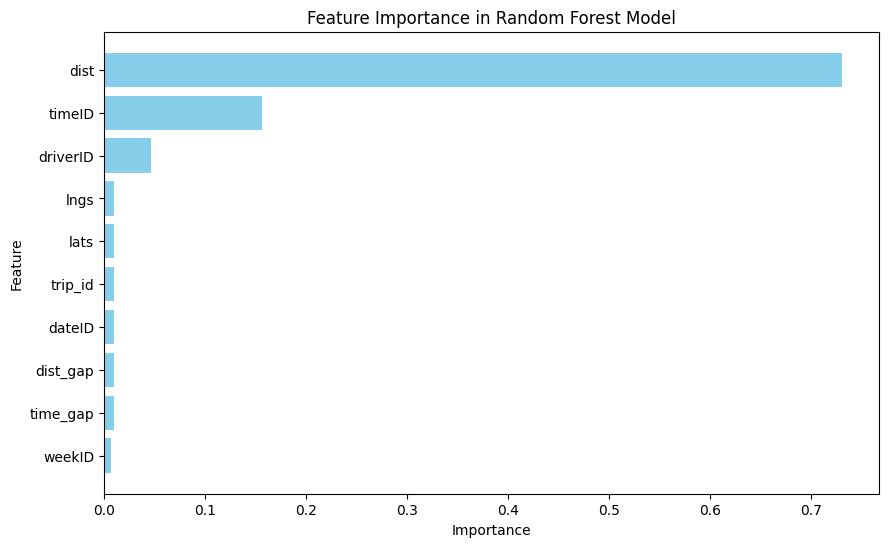

Feature  Importance
2      dist    0.730625
6    timeID    0.156357
4  driverID    0.046938
8      lngs    0.009847
3      lats    0.009845
0   trip_id    0.009828
7    dateID    0.009808
9  dist_gap    0.009763
1  time_gap    0.009714
5    weekID    0.007276

In [ ]:
feature_importances = model.feature_importances_

# Step 6: Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X_train_features.columns,
    'Importance': feature_importances
})

# Step 7: Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 8: Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

# Output the importance DataFrame for review
importance_df

### Step 6: Evaluate the Model with Learning Curves

In [ ]:
# Get current timestamp in Cairo time
cairo_tz = pytz.timezone('Africa/Cairo')
timestamp = datetime.now(cairo_tz).strftime('%Y-%m-%dT%H:%M:%S')

# Generate a unique label based on the timestamp
label = 'Model_Run_' + timestamp.replace(':', '').replace('-', '').split('.')[0]
# label = 'Model_Run_' + datetime.now().strftime("%Y%m%d_%H%M%S")

print(timestamp)
print(label)

2024-08-16T20:59:47
Model_Run_20240816T205947


In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(
    model, X_train.drop(columns=['trip_time']), y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5, scoring='neg_root_mean_squared_error')


fig = go.Figure()
fig.add_trace(go.Scatter(x=train_sizes, y=-np.mean(train_scores, axis=1), name='Training error'))
fig.add_trace(go.Scatter(x=train_sizes, y=-np.mean(valid_scores, axis=1), name='Validation error'))
fig.update_layout(
    title='Learning Curve: ' + label,
    xaxis_title='Number of Training Examples',
    yaxis_title='Root Mean Squared Error (RMSE)',
    legend_title='Error Type'
)
fig.show()

# Specify the directory and file name
output_directory = 'Careem_RFR_Figures/'  # Replace with your directory path
if not os.path.exists(output_directory):
    os.makedirs(output_directory)  # Create the directory if it doesn't exist
output_file = os.path.join(output_directory, f'learning_curve_v2.1_{label}.png')

# Save the figure
fig.write_image(output_file)

### Step 7: Make Predictions and Calculate Errors

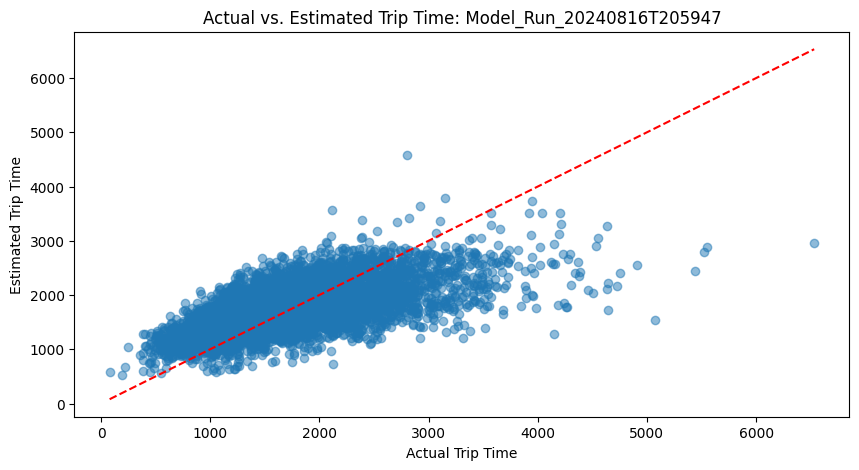

Mean Absolute Error (MAE): 390.49572726804627
R^2 Score: 0.4040463724914317


In [ ]:
def estimations(test_data, model, feature_names):
    features_data = test_data[feature_names]
    test_data['trip_time_estimate'] = model.predict(features_data)
    test_data['error'] = test_data['trip_time'] - test_data['trip_time_estimate']
    test_data = test_data.query("error < 3600")
    return test_data

# Get the feature names used during training
feature_names = X_train.drop(columns=['trip_time']).columns.tolist()

def plot_graphs(plot_df):
    plt.figure(figsize=(10, 5))
    plt.scatter(plot_df['trip_time'], plot_df['trip_time_estimate'], alpha=0.5)
    plt.plot([plot_df['trip_time'].min(), plot_df['trip_time'].max()], 
             [plot_df['trip_time'].min(), plot_df['trip_time'].max()], 'r--')
    plt.xlabel('Actual Trip Time')
    plt.ylabel('Estimated Trip Time')
    plt.title('Actual vs. Estimated Trip Time: ' + label)

    # Save the figure
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)  # Create the directory if it doesn't exist
    output_file = os.path.join(output_directory, f'actual_vs_estimated_v2.1_{label}.png')
    plt.savefig(output_file)
    plt.show()
    plt.close()

def get_metrics(plot_df):
    mae = mean_absolute_error(plot_df['trip_time'], plot_df['trip_time_estimate'])
    r2 = r2_score(plot_df['trip_time'], plot_df['trip_time_estimate'])
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R^2 Score: {r2}')
    return mae, r2

# Assuming plot_df is defined from the previous estimations step
plot_df = estimations(X_test, model, feature_names)
plot_graphs(plot_df)
mae, r2 = get_metrics(plot_df)

### Step 8: Log the results

In [ ]:
# Define the log file path
log_file_path = 'model_training_results_v2.1_log_.csv'

# Create a log file with headers if it doesn't exist
if not os.path.exists(log_file_path):
    with open(log_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Timestamp', 'Label', 'n_estimators', 'max_depth', 'min_samples_leaf', 'max_leaf_nodes', 'random_state', 'criterion', 'max_features', 'RMSE', 'MAE', 'R2_Score', 'Input_Data_Files', 'Contributor'])

def log_model_training(n_estimators, max_depth, min_samples_leaf, max_leaf_nodes, random_state, criterion, max_features, RMSE, MAE, R2_Score, input_data_files):
    # Log details into CSV file
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([timestamp, label, n_estimators, max_depth, min_samples_leaf, max_leaf_nodes, random_state, criterion, max_features, RMSE, MAE, R2_Score, input_data_files, contributor])


# Example usage
RMSE = rmse
MAE = mae
R2_Score = r2
# Convert list of files to a comma-separated string
input_data_files = ', '.join(files_names)
max_leaf_nodes = "Default"
criterion = "Default"
# input_data_files = 'clean_2024-01-25.json, clean_2024-01-26.json, clean_2024-01-27.json, clean_2024-01-28.json, clean_2024-01-29.json'

log_model_training(n_estimators, max_depth, min_samples_leaf, max_leaf_nodes, random_state, criterion, max_features, RMSE, MAE, R2_Score, input_data_files)


In [ ]:
from sklearn import tree
tree.plot_tree(model.estimators_[0])

[Text(0.5223511464497042, 0.9545454545454546, 'x[2] <= 7.22\nsquared_error = 475296.511\nsamples = 11772\nvalue = 1745.377'),
 Text(0.25737333579881655, 0.8636363636363636, 'x[2] <= 4.052\nsquared_error = 284669.619\nsamples = 6619\nvalue = 1443.2'),
 Text(0.3898622411242604, 0.9090909090909092, 'True  '),
 Text(0.11281897189349112, 0.7727272727272727, 'x[2] <= 2.21\nsquared_error = 222138.411\nsamples = 2863\nvalue = 1216.339'),
 Text(0.04571930473372781, 0.6818181818181818, 'x[2] <= 0.887\nsquared_error = 199776.172\nsamples = 912\nvalue = 1048.645'),
 Text(0.011926775147928994, 0.5909090909090909, 'x[4] <= 119.0\nsquared_error = 154802.722\nsamples = 125\nvalue = 797.264'),
 Text(0.004807692307692308, 0.5, 'x[5] <= 1.5\nsquared_error = 57997.652\nsamples = 11\nvalue = 526.812'),
 Text(0.0033284023668639054, 0.4090909090909091, 'squared_error = 27656.543\nsamples = 6\nvalue = 370.111'),
 Text(0.00628698224852071, 0.4090909090909091, 'squared_error = 24845.061\nsamples = 5\nvalue = 72

Error in callback <function _draw_all_if_interactive at 0x00000261B4E6B7E0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 